### Common Utilities

In [1]:
import os
# Move up to the parent folder
current_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(current_dir, "data", "singapore\\")
print(data_dir)

gym_file = data_dir + "GymsSGGEOJSON_202501.geojson"
hawker_file = data_dir + "HawkerCentresKML_202501.kml"
hdb_file = data_dir + "HDBExistingBuilding_202501.geojson"
master_land_file = data_dir + "MasterPlan2019LandUselayer_202501.geojson"
master_plan_file = data_dir + "MasterPlan2019PlanningAreaBoundaryNoSea_202501.geojson"
map_polygon_file = data_dir + "NationalMapPolygon_202501.kml"
park_file = data_dir + "ParkFacilities_202501.geojson"
preschool_file = data_dir + "PreSchoolsLocation_202501.geojson"
road_file = data_dir + "RoadNetwork_202501.kml"
tourist_file = data_dir + "TouristAttractions_202501.geojson"

c:\Users\meiro\Documents\1_project\trade-area-analysis\data\singapore\


In [2]:
import pandas as pd

def visualize_data(data_path):
    # Read data
    df = pd.read_csv(data_path, header=0)
    # Clean data 
    df.columns = df.columns.str.lower()

    print(f"there are {len(df)} rows of data")

    display(df.head(5))

    return df

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Polygon
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

def visualize_polygons(df, plot_title):
    # Convert the Coordinates column to Shapely Polygon objects
    # polygons = []
    # for index, row in df.iterrows():
    #     coordinates = row["coordinates"]
    #     print(coordinates)
    #     polygons.append(Polygon(coordinates))
    df["geometry"] = df["coordinates"].apply(Polygon)

    gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
    
    # Set CRS to WGS84 (latitude/longitude) and reproject to EPSG:3857 (Web Mercator)
    gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
    gdf = gdf.to_crs(epsg=3857)

    # Plot the polygons
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.7)

    # Add labels at the centroid of each polygon
    for x, y, label in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf["polygon_name"]):
        ax.text(x, y, label, fontsize=8, ha="center", color="red")
    
    # Add basemap using contextily (choose a suitable tile)
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    # Set the title and show the plot
    ax.set_title(f"{plot_title} in Singapore", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.legend()
    
    plt.show()

### Extract map polygon

In [4]:
# Convert kml file to csv
import xml.etree.ElementTree as ET
import csv

# Parse the KML file
tree = ET.parse(map_polygon_file)
root = tree.getroot()

# Namespace mapping
ns = {
    "kml": "http://www.opengis.net/kml/2.2",
    "gx": "http://www.google.com/kml/ext/2.2",
}

# Extract Placemark data for the road network
csv_data = []
for placemark in root.findall(".//kml:Placemark", ns):
    placemark_data = {}
    
    # Extract the attributes (NAME, FOLDERPATH, etc.)
    extended_data = placemark.find('.//kml:ExtendedData/kml:SchemaData', ns) 
    if extended_data is not None:
        for simple_data in extended_data.findall('.//kml:SimpleData', ns):
            key = simple_data.get('name')
            value = simple_data.text
            placemark_data[key] = value
    
    # Extract the coordinates
    coordinates = placemark.find('.//kml:coordinates', ns)
    if coordinates is not None:
        placemark_data['coordinates'] = coordinates.text.strip().replace("\n", " ").replace("\r", " ").replace('"', '""')
    
    csv_data.append(placemark_data)

# # Write extracted data to CSV
# csv_columns = set().union(*(d.keys() for d in csv_data))
# map_csv = data_dir + "map_polygon_202501.csv"
# with open(map_csv, mode="w", newline="", encoding="utf-8") as file:
#     writer = csv.DictWriter(file, fieldnames=csv_columns)
#     writer.writeheader()
#     writer.writerows(csv_data)

# print("data extracted to data folder")

In [5]:
# df_map = visualize_data(map_csv)
df_map = pd.DataFrame(csv_data)
df_map.head(5)

,NAME,FOLDERPATH,SYMBOLID,INC_CRC,FMEL_UPD_D,coordinates
0,SUNGEI KETAPANG,Layers/Hydrographic,4,26B5B7EC4633DE8B,20191008154614,"103.956411510644,1.3313555849612,0.0 103.95648..."
1,POND,Layers/Hydrographic,4,7F33336D573646A9,20191008154614,"103.957454966314,1.31878704975872,0.0 103.9572..."
2,SUNGEI BEDOK,Layers/Hydrographic,4,53B22D7F36B804E8,20191008154614,"103.960682455874,1.32115972827619,0.0 103.9622..."
3,POND,Layers/Hydrographic,4,E23B11191EE75B69,20191008154614,"103.962654805601,1.32080240444442,0.0 103.9626..."
4,SUNGEI BEDOK,Layers/Hydrographic,4,923CFEAAA00266B6,20191008154614,"103.962825103758,1.31628973774835,0.0 103.9634..."


In [6]:
# Format coordinates
def format_coordinates(coord_string):
    points = coord_string.split()  # Split by space to get individual points
    formatted = [
        [float(lon), float(lat)]  # Convert to [lon, lat] pairs
        for lon, lat, _ in (point.split(",") for point in points)
    ]
    return formatted

# Transform data for geopandas visualisation
df_map.columns = df_map.columns.str.lower()
df_map["coordinates_with_alt"] = df_map["coordinates"]
df_map["coordinates"] = df_map["coordinates_with_alt"].apply(format_coordinates)
df_map["polygon_name"] = None
df_map.head(1)

,name,folderpath,symbolid,inc_crc,fmel_upd_d,coordinates,coordinates_with_alt,polygon_name
0,SUNGEI KETAPANG,Layers/Hydrographic,4,26B5B7EC4633DE8B,20191008154614,"[[103.956411510644, 1.3313555849612], [103.956...","103.956411510644,1.3313555849612,0.0 103.95648...",None


In [7]:
import pandas as pd

# Get unique names from the 'name' column and remove NaN values
polygon_types = df_map["name"].dropna().unique()

# Sort the unique names in ascending order
sorted_polygon_types = sorted(polygon_types)

# Print the number of unique names and the names themselves
print(f"The number of unique names = {len(sorted_polygon_types)}")

# Save the sorted unique names to a CSV file
sorted_df = pd.DataFrame(sorted_polygon_types, columns=["Polygon Name"])
sorted_df.to_csv(data_dir+"sorted_polygon_names.csv", index=False)

print("sorted names have been saved to 'sorted_polygon_names.csv'")


The number of unique names = 203
sorted names have been saved to 'sorted_polygon_names.csv'


,name,folderpath,symbolid,inc_crc,fmel_upd_d,coordinates,coordinates_with_alt,polygon_name
96,104° 20’ 00” E,Layers/SMap_PedraBranca_Inset_Anno,0,BFE4D4505AC338CD,20191008154614,"[[104.400682140595, 1.3322980763538], [104.401...","104.400682140595,1.3322980763538,0.0 104.40119...",None
97,104° 40’ 00” E,Layers/SMap_PedraBranca_Inset_Anno,0,2C0E06DAF5AF77EC,20191008154614,"[[104.410638492326, 1.33232818322208], [104.41...","104.410638492326,1.33232818322208,0.0 104.4111...",None
98,1° 14’ 30” N,Layers/SMap_PedraBranca_Inset_Anno,0,4BAAB064C523E974,20191008154614,"[[104.404751534214, 1.32688870969518], [104.40...","104.404751534214,1.32688870969518,0.0 104.4047...",None
99,1° 29’ 30” N,Layers/SMap_PedraBranca_Inset_Anno,0,7083BE1A48652E2B,20191008154614,"[[104.404724472238, 1.33441030721165], [104.40...","104.404724472238,1.33441030721165,0.0 104.4047...",None


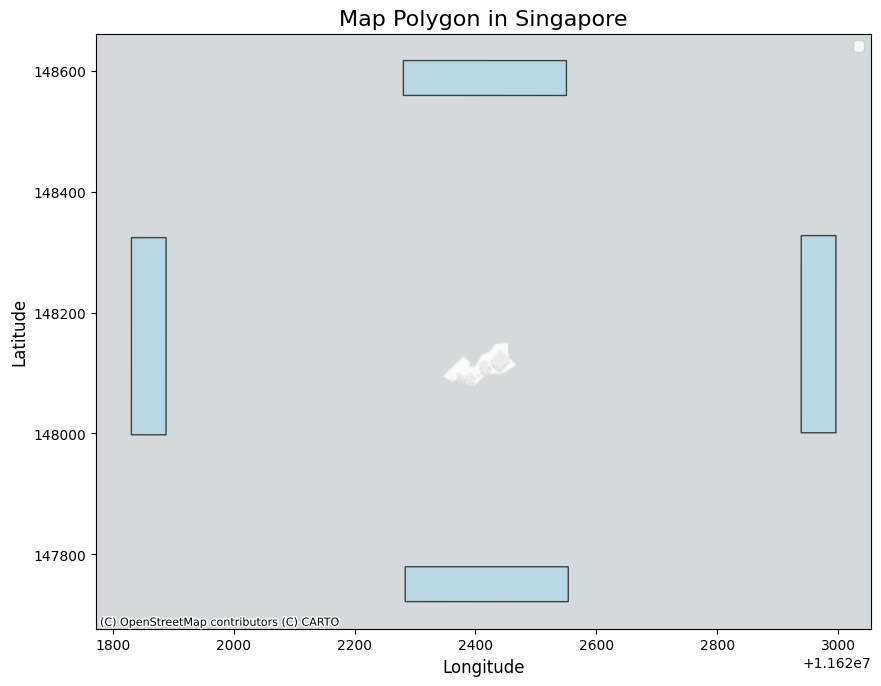

In [8]:
outliers = df_map[df_map["name"].isin(["104° 20’ 00” E", "104° 40’ 00” E", "1° 14’ 30” N", "1° 29’ 30” N"])]
display(outliers)
visualize_polygons(outliers, 'Map Polygon')

,name,folderpath,symbolid,inc_crc,fmel_upd_d,coordinates,coordinates_with_alt,polygon_name
497,LINKWAY,Layers/Coastal_Outlines,6,8A8FCE6DFDFA7B84,20191008154614,"[[103.710825895644, 1.30844817634865], [103.71...","103.710825895644,1.30844817634865,0.0 103.7112...",None
536,LINKWAY,Layers/Coastal_Outlines,6,CC672892905C847D,20191008154614,"[[103.698157322752, 1.30861796767103], [103.69...","103.698157322752,1.30861796767103,0.0 103.6982...",None
537,LINKWAY,Layers/Coastal_Outlines,6,E73DCF62B45A1FFA,20191008154614,"[[103.815070901064, 1.26440917515456], [103.81...","103.815070901064,1.26440917515456,0.0 103.8149...",None
540,LINKWAY,Layers/Coastal_Outlines,6,FC35C4045CBB891B,20191008154614,"[[103.764857071035, 1.2300721557863], [103.764...","103.764857071035,1.2300721557863,0.0 103.76499...",None
541,LINKWAY,Layers/Coastal_Outlines,6,D4EC754966E36EEA,20191008154614,"[[103.760326062111, 1.23328692063138], [103.76...","103.760326062111,1.23328692063138,0.0 103.7604...",None
572,LINKWAY,Layers/Coastal_Outlines,6,C1E17F7D72B12220,20191008154614,"[[103.711919245607, 1.29961277958585], [103.71...","103.711919245607,1.29961277958585,0.0 103.7118...",None
573,LINKWAY,Layers/Coastal_Outlines,6,AAB6238404C5BD64,20191008154614,"[[103.823684079059, 1.26290471824743], [103.82...","103.823684079059,1.26290471824743,0.0 103.8241...",None
574,LINKWAY (JOHOR),Layers/Coastal_Outlines,6,C3E2E3F884B42C85,20191008154614,"[[103.633298594087, 1.35081267177119], [103.63...","103.633298594087,1.35081267177119,0.0 103.6331...",None
579,LINKWAY (SINGAPORE),Layers/Coastal_Outlines,6,74647C99C4550E3C,20191008154614,"[[103.633121449873, 1.3504592363541], [103.633...","103.633121449873,1.3504592363541,0.0 103.63329...",None
583,LINKWAY,Layers/Coastal_Outlines,6,ADC254BDDDC6A720,20191008154614,"[[103.867330715165, 1.42472406287363], [103.86...","103.867330715165,1.42472406287363,0.0 103.8673...",None


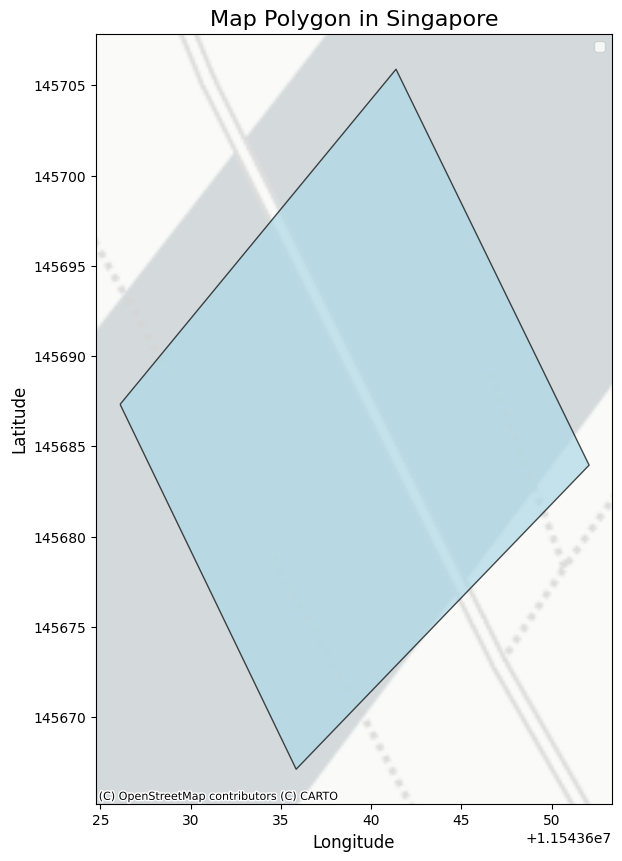

In [9]:
linkway = df_map[df_map["name"].str.contains("LINKWAY", na=False)]
display(linkway)
visualize_polygons(linkway[1:2], 'Map Polygon')

In [10]:
# Remove outliers 
df_map = df_map[~df_map["name"].isin(["104° 20’ 00” E", "104° 40’ 00” E", "1° 14’ 30” N", "1° 29’ 30” N"])]

,name,folderpath,symbolid,inc_crc,fmel_upd_d,coordinates,coordinates_with_alt,polygon_name
423,BISHAN - ANG MO KIO PARK,Layers/Parks_NaturalReserve,5,9C11DCFB5847A971,20191008154614,"[[103.848522564159, 1.36292735685912], [103.84...","103.848522564159,1.36292735685912,0.0 103.8485...",None
424,BISHAN - ANG MO KIO PARK,Layers/Parks_NaturalReserve,5,C59FD10777B41628,20191008154614,"[[103.833678905128, 1.36706574361972], [103.83...","103.833678905128,1.36706574361972,0.0 103.8338...",None
425,BISHAN - ANG MO KIO PARK,Layers/Parks_NaturalReserve,5,C6CD0D03903D917F,20191008154614,"[[103.846007865135, 1.36059374255531], [103.84...","103.846007865135,1.36059374255531,0.0 103.8459...",None


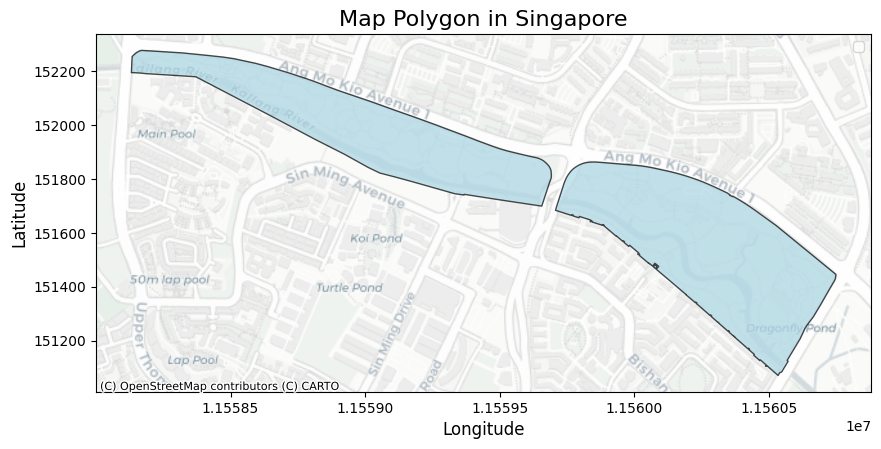

In [11]:
bishan = df_map[df_map["name"].str.contains("BISHAN", na=False)]
display(bishan)
visualize_polygons(bishan, 'Map Polygon')

,name,folderpath,symbolid,inc_crc,fmel_upd_d,coordinates,coordinates_with_alt,polygon_name
509,EAST COAST PARK AREA B,Layers/Parks_NaturalReserve,5,D342CAE667A42ED9,20191008154614,"[[103.885260847248, 1.29440255527319], [103.88...","103.885260847248,1.29440255527319,0.0 103.8852...",None
510,EAST COAST PARK AREA C,Layers/Parks_NaturalReserve,5,B60F5C90495276DE,20191008154614,"[[103.919298769048, 1.30296935041059], [103.91...","103.919298769048,1.30296935041059,0.0 103.9193...",None
511,EAST COAST PARK AREA E,Layers/Parks_NaturalReserve,5,DE8F8E26C71465B7,20191008154614,"[[103.929359356839, 1.30472162129468], [103.92...","103.929359356839,1.30472162129468,0.0 103.9293...",None
512,EAST COAST PARK AREA E,Layers/Parks_NaturalReserve,5,29134E92F7EDF45E,20191008154614,"[[103.929356716907, 1.30472146674991], [103.92...","103.929356716907,1.30472146674991,0.0 103.9293...",None
513,EAST COAST PARK AREA F,Layers/Parks_NaturalReserve,5,51CDA5F7A87B911C,20191008154614,"[[103.938208482629, 1.30765060769711], [103.93...","103.938208482629,1.30765060769711,0.0 103.9382...",None


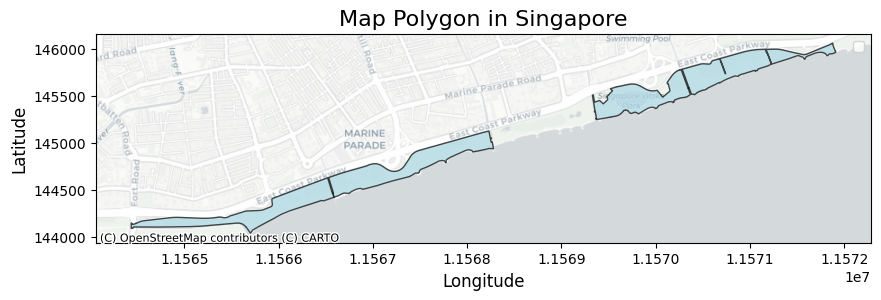

In [ ]:
ecp = df_map[df_map["name"].str.contains("EAST COAST", na=False)]
display(ecp)
visualize_polygons(ecp, 'Map Polygon')

#data missing? --> east coast park has a to h, some areas are missing?
## there are exact duplicates 

### Extract planning area

In [13]:
import re
import json
import csv

# Load the geoJSON data
with open(master_plan_file) as f:
    geojson_data = json.load(f)

# Extract column names dynamically from the Description field
description_sample = geojson_data["features"][0]["properties"]["Description"]
columns = re.findall(r"<th>(.*?)<\/th>", description_sample)

# Prepare the CSV data
csv_data = []
for feature in geojson_data["features"]:
    properties = feature["properties"]
    description = properties.get("Description", "")
    
    # Extract values dynamically for each column
    values = re.findall(r"<td>(.*?)<\/td>", description)
    
    # Fill missing columns with empty strings if there are fewer values than columns
    values.extend([""] * (len(columns) - len(values)))
    
    row = dict(zip(columns, values))
    
    # Add geometry coordinates (longitude, latitude)
    row["coordinates"] =  feature["geometry"]["coordinates"]
    # # Handle cases where coordinates are multi-dimensional (e.g., MultiPolygon)
    # if len(coords) > 0 and len(coords[0]) > 0:
    #     row["lon"] = coords[0][0][0]  # Assuming the first coordinate is longitude
    #     row["lat"] = coords[0][0][1]  # Assuming the second coordinate is latitude
    
    csv_data.append(row)

# # coordinates too long, need to manipulated to be stored to different cells 
# # Write to a CSV file
# planningarea_csv = data_dir + "planning_area_202501.csv"
# with open(planningarea_csv, mode="w", newline="", encoding="utf-8") as file:
#     writer = csv.DictWriter(file, fieldnames=columns + ["lon", "lat"])
#     writer.writeheader()
#     writer.writerows(csv_data)

# print(f"data extracted to folder")


In [14]:
df_pa = pd.DataFrame(csv_data)
df_pa = df_pa.columns.str.lower()

In [15]:
# Function to remove the altitude (third element) from each coordinate
def sanitize_coordinates(coords):
    coords = coords[0]  # Flatten the list 
    return [coord[:2] for coord in coords]

df_pa = pd.DataFrame(csv_data)
df_pa.columns = df_pa.columns.str.lower()
df_pa["coordinates_with_alt"] = df_pa["coordinates"]
df_pa["coordinates"] = df_pa["coordinates_with_alt"].apply(sanitize_coordinates)
df_pa["polygon_name"] = df_pa["pln_area_n"]
df_pa.head(5)

,pln_area_n,pln_area_c,ca_ind,region_n,region_c,inc_crc,fmel_upd_d,coordinates,coordinates_with_alt,polygon_name
0,BEDOK,BD,N,EAST REGION,ER,5F00E6FF084F3364,20191223152014,"[[103.932080144934, 1.3055476965106], [103.932...","[[[103.932080144934, 1.3055476965106, 0.0], [1...",BEDOK
1,BOON LAY,BL,N,WEST REGION,WR,C96AED188C00B2FC,20191223152014,"[[103.720424356295, 1.32823958886107], [103.72...","[[[103.720424356295, 1.32823958886107, 0.0], [...",BOON LAY
2,BUKIT BATOK,BK,N,WEST REGION,WR,3BEC4C829160F28A,20191223152014,"[[103.764078848716, 1.37001140859472], [103.76...","[[[103.764078848716, 1.37001140859472, 0.0], [...",BUKIT BATOK
3,BUKIT MERAH,BM,N,CENTRAL REGION,CR,4850795BB0B6A4F7,20191223152014,"[[103.823614644329, 1.26017768291763], [103.82...","[[[103.823614644329, 1.26017768291763, 0.0], [...",BUKIT MERAH
4,BUKIT PANJANG,BP,N,WEST REGION,WR,656F87D23D6DAB02,20191223152014,"[[103.774450261573, 1.39028945327265], [103.77...","[[[103.774450261573, 1.39028945327265, 0.0], [...",BUKIT PANJANG


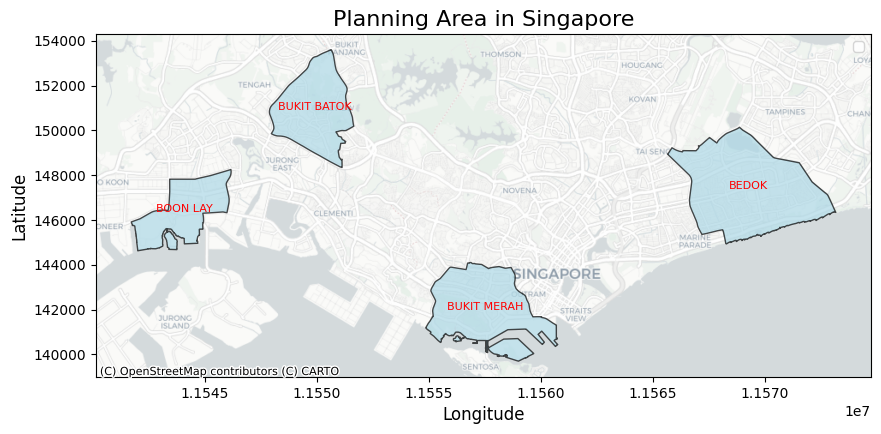

In [26]:
visualize_polygons(df_pa[:4], "Planning Area")

### Count number of gyms within each planning area 

<p> To determine if a point falls within a polygon and count those occurrences, we can use spatial functions in SQL, 
    specifically with PostGIS (a spatial database extension for PostgreSQL). 
</p>

In [17]:
# Use shapely for temp calculation 
from shapely.geometry import Point, Polygon

def check_inclusion(polygon,points):
    # Define the polygon (list of coordinates)
    polygon = Polygon(polygon)

    # Check if each point is inside the polygon and count them
    inside_count = 0
    point_collection = {}
    for name, point in points.items():
        point = Point(point)
        if point.within(polygon):
            print(f"{name} is inside polygon")
            inside_count += 1
            point_collection[name]= point

    # Print results
    print("---------------------------------------")
    print(f"Number of points inside the polygon: {inside_count}")
    
    return point_collection

In [18]:
gym_csv = data_dir + "gym_202501.csv"
df_gym = visualize_data(gym_csv)

there are 159 rows of data


,landyaddresspoint,landxaddresspoint,addresspostalcode,addressbuildingname,hyperlink,photourl,addressunitnumber,addressfloornumber,addressstreetname,addressblockhousenumber,description,inc_crc,fmel_upd_d,name,lon,lat
0,0,0,78989,NaN,NaN,NaN,NaN,NaN,Tras Street,50,Operating Hours: 7.00am - 10.00am,0E28997B4498C8C3,20160127095840,The Pit,103.844202,1.278114
1,0,0,287992,House J and S,NaN,NaN,NaN,NaN,Turf Club Road,100,"Operating Hours: Monday, Wednesday, Friday: 1...",CAA5268B7BA8784D,20160127095840,The Stable Mixed Martial Arts,103.795898,1.334220
2,0,0,579783,NaN,NaN,NaN,NaN,NaN,Bishan St. 4,5,Facilities: Standard Gymnasium Equipment Opera...,E7A4A38558FA4D85,20160127095840,Bishan ClubFITT Gym,103.850922,1.355283
3,0,0,208568,King George's Building,NaN,NaN,NaN,NaN,King George's Ave,328,NaN,CBB24D03E2FE458E,20160127095840,The Yoga Place,103.862091,1.309922
4,0,0,559022,NaN,NaN,NaN,10,1,Bughley Drive Blk B,45,NaN,51E0C317DBD72838,20160127095840,Sky Fitness - Serangoon Gardens,103.859571,1.360010


In [19]:
from shapely.geometry import Point
df_gym["coordinates"] = [xy for xy in zip(df_gym["lon"], df_gym["lat"])]
dict_gym = dict(zip(df_gym["name"], df_gym["coordinates"]))
print(dict_gym)

{'The Pit': (103.844202079592, 1.27811388348071), 'The Stable Mixed Martial Arts': (103.795898242377, 1.3342195983767), 'Bishan ClubFITT Gym': (103.850922071159, 1.35528262760188), 'The Yoga Place': (103.862090963732, 1.30992191079359), 'Sky Fitness - Serangoon Gardens': (103.85957105374, 1.36000966368369), 'Slender Shapes - Serangoon Gardens Way': (103.864884313373, 1.36389982541919), 'Woodlands ClubFITT Gym': (103.780306573729, 1.43489537703518), 'Yio Chu Kang ClubFITT Gym': (103.845767858372, 1.38227243116352), 'Yishun ClubFITT Gym': (103.83117739651, 1.41201836574556), 'Zattva Yoga Studio': (103.841150152248, 1.30125729612721), 'Fitness First - One Raffles Quay': (103.851677105821, 1.28089478900143), 'Fitness First - Paragon': (103.835240311923, 1.30372322367268), 'True Fitness - Great World City': (103.831757911005, 1.29380236091495), 'California Fitness - Bugis': (103.855786976518, 1.30014248326867), 'Fitness First - AMK Hub': (103.848399235571, 1.36924890739398), 'California Fit

In [20]:
bishan = df_pa[df_pa["pln_area_n"].str.contains("BISHAN", na=False)]
display(bishan)

bishan_coordinates = bishan["coordinates"].values[0]
print(bishan_coordinates)

,pln_area_n,pln_area_c,ca_ind,region_n,region_c,inc_crc,fmel_upd_d,coordinates,coordinates_with_alt,polygon_name
50,BISHAN,BS,N,CENTRAL REGION,CR,741583155DB92ACF,20191223152014,"[[103.842966122963, 1.36428680712807], [103.84...","[[[103.842966122963, 1.36428680712807, 0.0], [...",BISHAN


[[103.842966122963, 1.36428680712807], [103.842965858784, 1.36428660274281], [103.842966065454, 1.36428663710781], [103.8429662883, 1.36428669227314], [103.842966631553, 1.36428676642962], [103.843267180989, 1.3642645124115], [103.843267207047, 1.36426451150703], [103.843493114243, 1.36425072081074], [103.843701918102, 1.36424021029673], [103.843909700297, 1.36423188019137], [103.844124224456, 1.36422550436883], [103.844348752384, 1.36422125011967], [103.844552084818, 1.36420285440421], [103.844793822039, 1.36418098482442], [103.845054306974, 1.36415741854094], [103.845309955813, 1.36413428906133], [103.845542230202, 1.364113274982], [103.845783248479, 1.36407776025728], [103.845989847121, 1.36404731736581], [103.84617709953, 1.36400663353905], [103.84654662537, 1.36392635562823], [103.847616515201, 1.36358551627633], [103.847891428626, 1.36345856447976], [103.848160033165, 1.36332972799567], [103.84841485006, 1.36320240185692], [103.848657740244, 1.36307629846814], [103.848903680101, 

In [21]:
point_collection = check_inclusion(bishan_coordinates, dict_gym)

Bishan ClubFITT Gym is inside polygon
Amore Fitness - Thomson Plaza is inside polygon
Midview Body & Mind is inside polygon
PowerMoves Pilates - Bishan Park is inside polygon
Green Yoga is inside polygon
---------------------------------------
Number of points inside the polygon: 5
{'Bishan ClubFITT Gym': <POINT (103.851 1.355)>, 'Amore Fitness - Thomson Plaza': <POINT (103.831 1.355)>, 'Midview Body & Mind': <POINT (103.834 1.358)>, 'PowerMoves Pilates - Bishan Park': <POINT (103.847 1.363)>, 'Green Yoga': <POINT (103.835 1.353)>}


In [22]:
for index, value in point_collection.items():
    print(index, value)
    print(value.x, value.y)

Bishan ClubFITT Gym POINT (103.850922071159 1.35528262760188)
103.850922071159 1.35528262760188
Amore Fitness - Thomson Plaza POINT (103.830919788426 1.35466901882051)
103.830919788426 1.35466901882051
Midview Body & Mind POINT (103.833930717119 1.35821656561939)
103.833930717119 1.35821656561939
PowerMoves Pilates - Bishan Park POINT (103.84749323637 1.36254434770061)
103.84749323637 1.36254434770061
Green Yoga POINT (103.835093523472 1.35306949447786)
103.835093523472 1.35306949447786


In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Polygon, Point
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

def visualize_points_on_polygons(polygon, points_dict, plot_title):
    # Convert the polygon coordinates into a Shapely Polygon object
    polygon = Polygon(polygon)
    
    # Create GeoDataFrame for the polygon
    gdf_polygon = gpd.GeoDataFrame(geometry=[polygon], crs="EPSG:4326")
    
    # Set CRS to WGS84 (latitude/longitude) and reproject to EPSG:3857 (Web Mercator)
    gdf_polygon = gdf_polygon.to_crs(epsg=3857)
    
    # Create a GeoDataFrame for points
    points_geom = [Point(p) for p in points_dict.values()]  # Create Point objects from the coordinates
    gdf_points = gpd.GeoDataFrame(geometry=points_geom, crs="EPSG:4326")
    
    # Reproject points to match the CRS of the polygon
    gdf_points = gdf_points.to_crs(epsg=3857)

    # Plot the polygons
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_polygon.plot(ax=ax, color="lightblue", edgecolor="black", alpha=0.7)

    # Plot points on the same plot
    gdf_points.plot(ax=ax, color='red', markersize=50, label="Points")
    
    # # Add labels at the points based on the dictionary
    # for label, point in points_dict.items():
    #     # Extract the x and y coordinates from the Point object
    #     x, y = point.x, point.y
    #     ax.text(x, y, label, fontsize=8, ha="center", color="black")
    
    # Add basemap using contextily (choose a suitable tile)
    ctx.add_basemap(ax, crs=gdf_polygon.crs.to_string(), source=ctx.providers.CartoDB.Positron)

    # Set the title and show the plot
    ax.set_title(f"{plot_title} in Singapore", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    ax.legend()
    
    plt.show()

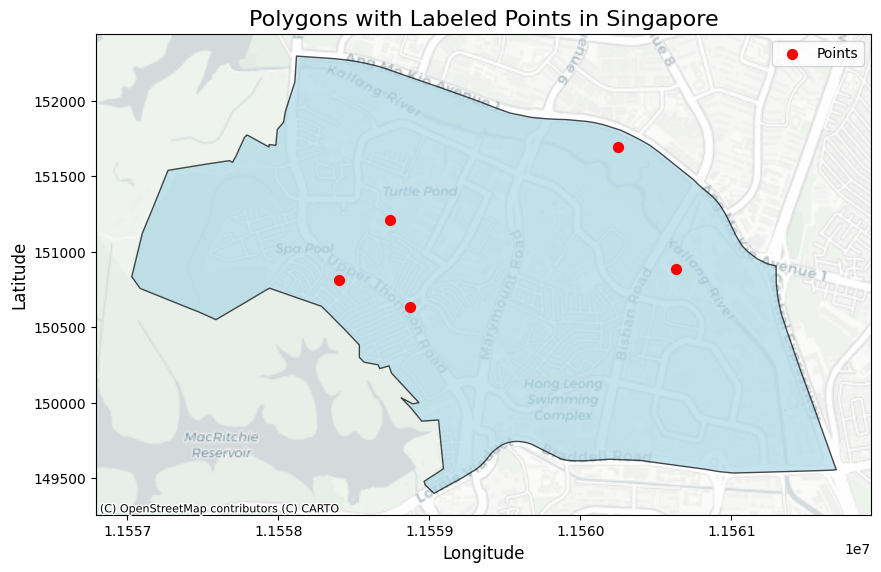

In [24]:
visualize_points_on_polygons(bishan_coordinates, point_collection, "Polygons with Labeled Points")

In [25]:
# Optimize code for handling large-scale calculations.

<p> save data to shp file </p>